### Deterministic Optimal Stopping

In [1]:
# Problem: Dynamic programming example for optimal cake eating
# You have a piece of cake that must be eaten over a period of T days.
# On any given day t, you may either:
#   - Eat the cake, gaining utility u_t = v_t + ε_t
#   - Delay eating to a future day, with zero utility for that day but a chance of positive utility in the future.

# The decision is irreversible (once eaten, the cake cannot be eaten again).
# The goal is to find the optimal day to eat the cake by maximizing expected utility across all days.
# The utility is given for 3 days in this example: u1 = 2, u2 = 3, u3 = 1.

# Define utilities for each day
u = [2, 3, 1]  # u1 = 2, u2 = 3, u3 = 1

# Number of days
T = len(u)

# Initialize value function V
V = [0] * T

# Start with the last day where V_T = u_T
V[T-1] = u[T-1]

# Compute V_t recursively
for t in range(T-2, -1, -1):
    V[t] = max(u[t], V[t+1])

# Find the optimal day to eat the cake
optimal_day = None
for t in range(T):
    if u[t] > V[t+1]:
        optimal_day = t + 1  # Days are 1-indexed
        break

# Output the result
optimal_day, V


(2, [3, 3, 1])

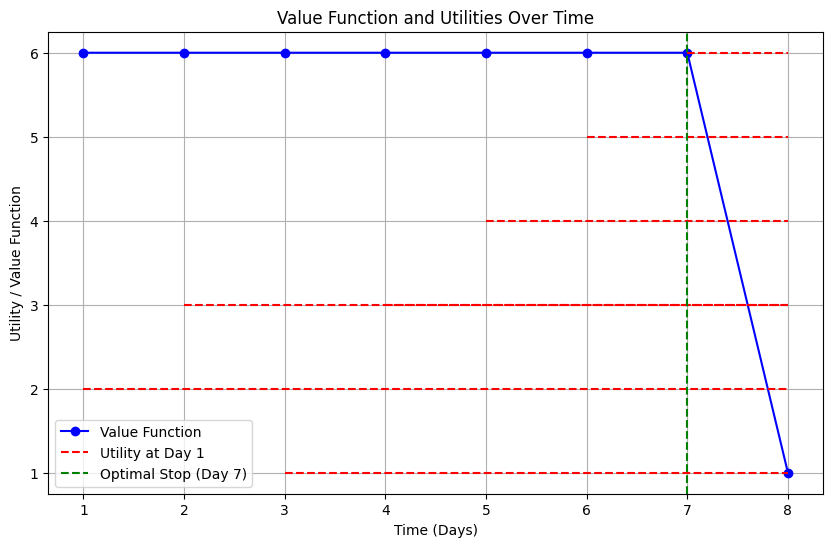

In [2]:
import matplotlib.pyplot as plt

def optimal_stopping_problem(u):
    """
    Solves a general optimal stopping problem.

    Parameters:
    u (list): List of utility values for each time period.

    Returns:
    optimal_day (int): The optimal day to stop (1-indexed).
    V (list): List of computed value functions for each day.
    """
    
    T = len(u)  # Number of time periods
    V = [0] * T  # Initialize the value function V

    # Base case: On the last day, the only choice is to stop
    V[T-1] = u[T-1]

    # Recursive case: Compute V_t for t = T-1, ..., 1
    for t in range(T-2, -1, -1):
        V[t] = max(u[t], V[t+1])  # Decide whether to stop or continue

    # Find the first day where stopping is optimal
    optimal_day = None
    for t in range(T-1):  # Go through all days except the last one
        if u[t] > V[t+1]:  # If stopping today is better than waiting
            optimal_day = t + 1  # Store the optimal day (1-indexed)
            break
    if optimal_day is None:
        optimal_day = T  # Stop on the last day if no better day was found

    return optimal_day, V


# Example usage
utilities = [2, 3, 1, 3, 4, 5, 6, 1]  # Utility for each day (this can be generalized)
optimal_day, value_function = optimal_stopping_problem(utilities)

optimal_day, value_function


# Plotting the results
time = list(range(1, len(utilities) + 1))

plt.figure(figsize=(10, 6))

# Plot value function
plt.plot(time, value_function, marker='o', label='Value Function', color='blue')

# Plot utilities as horizontal lines
for t in range(len(utilities)):
    plt.hlines(utilities[t], xmin=t+1, xmax=len(utilities), colors='red', linestyles='dashed', label=f'Utility at Day {t+1}' if t == 0 else "")

# Indicate optimal stopping day
plt.axvline(optimal_day, color='green', linestyle='--', label=f'Optimal Stop (Day {optimal_day})')

# Labels and legend
plt.xlabel('Time (Days)')
plt.ylabel('Utility / Value Function')
plt.title('Value Function and Utilities Over Time')
plt.legend()
plt.grid(True)

plt.show()

### Stochastic Optimal Stopping

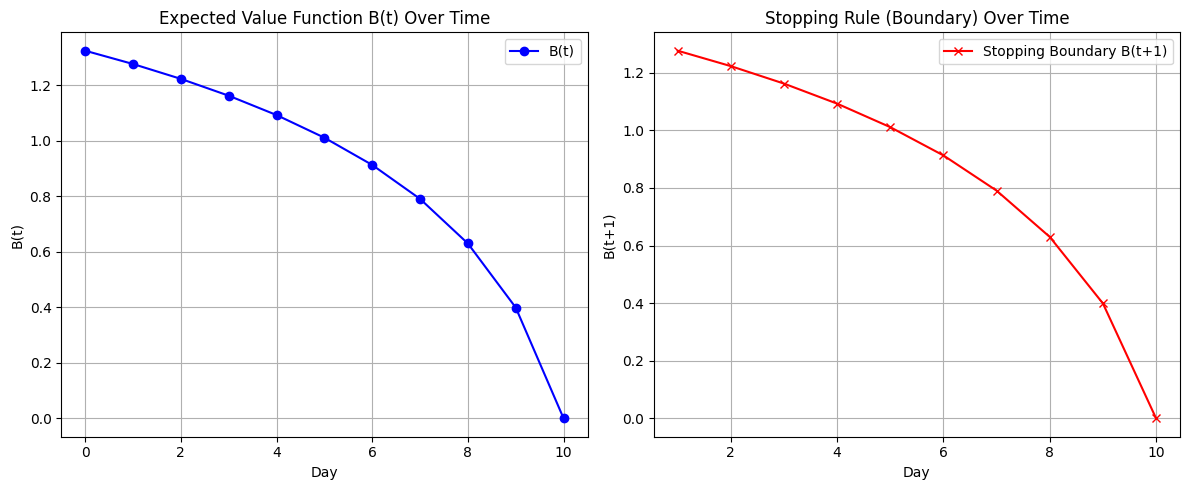

In [3]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# Parameters
T = 10  # Final time period
mu = 0  # Mean of the mood distribution
sigma = 1  # Standard deviation of the mood distribution

# Define the distribution of the mood
def f_eps(epsilon):
    return norm.pdf(epsilon, mu, sigma)

def F_eps(epsilon):
    return norm.cdf(epsilon, mu, sigma)

def E_eps_greater_than_B(B_t):
    """Compute the conditional expectation E[epsilon_t | epsilon_t > B_t]."""
    trunc_prob = 1 - F_eps(B_t)
    if trunc_prob == 0:
        return B_t  # To avoid division by zero in extreme cases
    return (mu + sigma * (norm.pdf((B_t - mu) / sigma) / trunc_prob))

# Compute B(t) recursively
def compute_B(T, mu, sigma):
    B = np.zeros(T + 1)  # Initialize B(t) for t = 0 to T

    # Set B(T) = 0 since there is no future utility
    B[T] = 0

    # Value function iteration (backwards)
    for t in range(T - 1, -1, -1):
        # Define a function for the integral E_t[max{epsilon_t, B(t+1)}]
        B_next = B[t + 1]
        
        # Compute the integral: E[max(epsilon_t, B(t+1))]
        B[t] = (B_next * F_eps(B_next)) + (E_eps_greater_than_B(B_next) * (1 - F_eps(B_next)))
    
    return B

# Compute B(t) using the parameters
B = compute_B(T, mu, sigma)

# Function for the stopping rule
def stopping_rule(B):
    stopping_boundaries = B[1:]  # B(t+1) for each t < T
    return stopping_boundaries

# Compute the stopping boundaries
stopping_boundaries = stopping_rule(B)

# Plot B(t) and the stopping boundaries in a 1x2 grid
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot B(t)
ax[0].plot(range(T + 1), B, marker='o', label='B(t)', color='blue')
ax[0].set_title('Expected Value Function B(t) Over Time')
ax[0].set_xlabel('Day')
ax[0].set_ylabel('B(t)')
ax[0].grid(True)
ax[0].legend()

# Plot the stopping boundary B(t+1)
ax[1].plot(range(1, T + 1), stopping_boundaries, marker='x', label='Stopping Boundary B(t+1)', color='red')
ax[1].set_title('Stopping Rule (Boundary) Over Time')
ax[1].set_xlabel('Day')
ax[1].set_ylabel('B(t+1)')
ax[1].grid(True)
ax[1].legend()

plt.tight_layout()
plt.show()

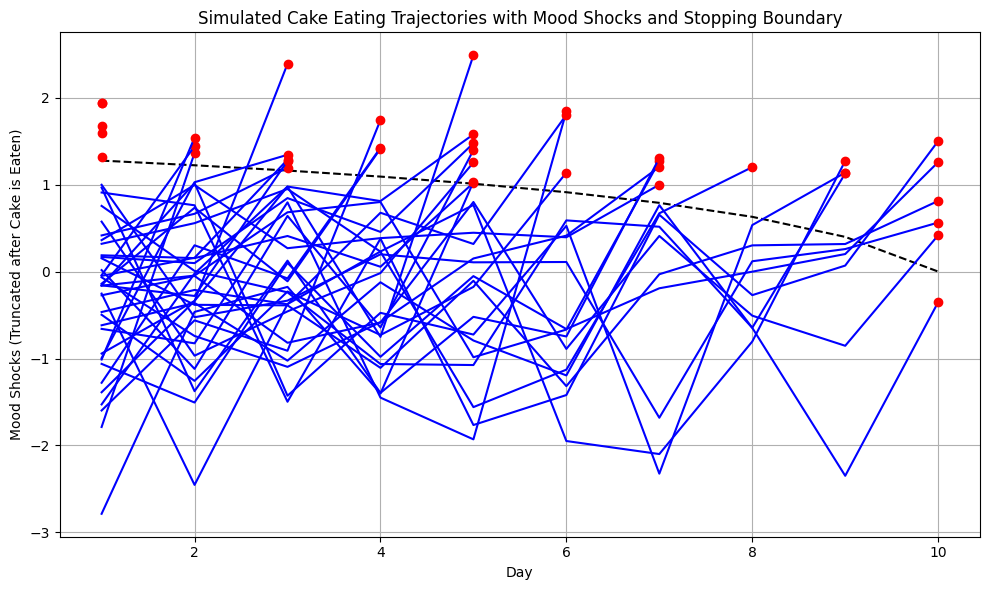

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters
T = 10  # Final time period
mu = 0  # Mean of the mood distribution
sigma = 1  # Standard deviation of the mood distribution
num_simulations = 40  # Number of simulations

# Function to simulate cake-eating decisions based on mood shocks
def simulate_cake_eating(num_simulations, T, mu, sigma, stopping_boundaries):
    results = []
    
    for sim in range(num_simulations):
        # Generate mood shocks for each day
        shocks = np.random.normal(mu, sigma, T)

        # Determine the day the cake is eaten based on the stopping rule
        for t in range(T):
            if shocks[t] > stopping_boundaries[t]:
                eat_day = t + 1  # Days are indexed from 1 to T
                break
        else:
            eat_day = T  # Eat on the last day if no earlier stopping condition is met

        # Truncate the shocks after the eating day
        truncated_shocks = shocks.copy()
        truncated_shocks[eat_day:] = np.nan  # Set shocks after eating to NaN for plotting

        results.append((truncated_shocks, eat_day))

    return results

# Run the simulation
simulation_results = simulate_cake_eating(num_simulations, T, mu, sigma, stopping_boundaries)

# Plot the trajectories in the same color, with red markers at the eating day
plt.figure(figsize=(10, 6))

# Plot B(t+1), the boundary for eating the cake
plt.plot(range(1, T + 1), stopping_boundaries, '--', color='black', label='B(t+1): Stopping Boundary')

for shocks, eat_day in simulation_results:
    # Plot the same color for the trajectory
    plt.plot(range(1, T + 1), shocks, color='blue')

    # Highlight the day the cake is eaten
    plt.plot(eat_day, shocks[eat_day - 1], 'ro')  # Red marker at the eating point

# Add title and labels
plt.title('Simulated Cake Eating Trajectories with Mood Shocks and Stopping Boundary')
plt.xlabel('Day')
plt.ylabel('Mood Shocks (Truncated after Cake is Eaten)')
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()


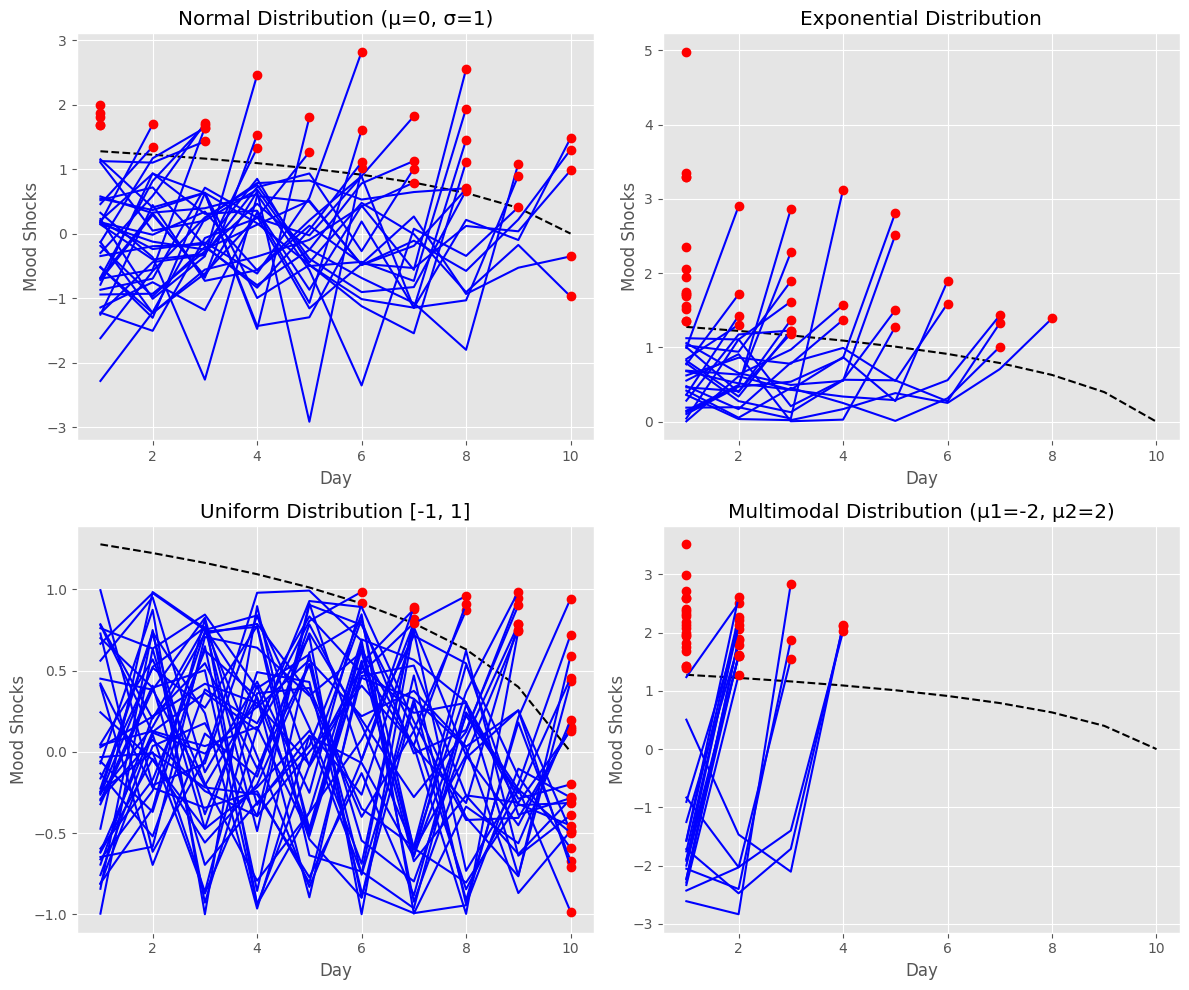

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, uniform, expon

# Use ggplot style for nicer plots
plt.style.use('ggplot')

# Parameters
T = 10  # Final time period
num_simulations = 40  # Number of simulations

# General function to compute mood shocks from any distribution
def generate_mood_shocks(distribution, T, **kwargs):
    if distribution == "normal":
        mu = kwargs.get("mu", 0)
        sigma = kwargs.get("sigma", 1)
        return np.random.normal(mu, sigma, T)
    elif distribution == "uniform":
        low = kwargs.get("low", 0)
        high = kwargs.get("high", 1)
        return np.random.uniform(low, high, T)
    elif distribution == "exponential":
        scale = kwargs.get("scale", 1)
        return np.random.exponential(scale, T)
    elif distribution == "multimodal":
        mu1, sigma1 = kwargs.get("mu1", -2), kwargs.get("sigma1", 1)
        mu2, sigma2 = kwargs.get("mu2", 2), kwargs.get("sigma2", 1)
        data = np.concatenate([
            np.random.normal(mu1, sigma1, T // 2),
            np.random.normal(mu2, sigma2, T // 2)
        ])
        np.random.shuffle(data)  # Shuffle to mix the modes
        return data
    else:
        raise ValueError("Unsupported distribution")

# Compute B(t) recursively
def compute_B(T, mu, sigma):
    B = np.zeros(T + 1)  # Initialize B(t) for t = 0 to T

    # Set B(T) = 0 since there is no future utility
    B[T] = 0

    # Value function iteration (backwards)
    for t in range(T - 1, -1, -1):
        # Define a function for the integral E_t[max{epsilon_t, B(t+1)}]
        B_next = B[t + 1]
        F_eps_next = norm.cdf(B_next, mu, sigma)
        E_eps_greater_next = mu + sigma * (norm.pdf(B_next, mu, sigma) / (1 - F_eps_next))
        B[t] = B_next * F_eps_next + E_eps_greater_next * (1 - F_eps_next)
    
    return B

# Function for the stopping rule
def stopping_rule(B):
    stopping_boundaries = B[1:]  # B(t+1) for each t < T
    return stopping_boundaries

# Simulate mood shock trajectories
def simulate_cake_eating(num_simulations, T, stopping_boundaries, distribution, **kwargs):
    results = []

    for sim in range(num_simulations):
        # Generate mood shocks for each simulation
        shocks = generate_mood_shocks(distribution, T, **kwargs)

        # Determine the day the cake is eaten based on the stopping rule
        for t in range(T):
            if shocks[t] > stopping_boundaries[t]:
                eat_day = t + 1  # Days are indexed from 1 to T
                break
        else:
            eat_day = T  # Eat on the last day if no earlier stopping condition is met

        # Truncate the shocks after the eating day
        truncated_shocks = shocks.copy()
        truncated_shocks[eat_day:] = np.nan  # Set shocks after eating to NaN for plotting

        results.append((truncated_shocks, eat_day))

    return results

# Function to plot the boundary and trajectories
def plot_trajectories_and_boundary(ax, stopping_boundaries, simulation_results, title):
    # Plot B(t+1), the boundary for eating the cake
    ax.plot(range(1, T + 1), stopping_boundaries, '--', color='black', label='B(t+1): Stopping Boundary')

    for shocks, eat_day in simulation_results:
        ax.plot(range(1, T + 1), shocks, color='blue')
        ax.plot(eat_day, shocks[eat_day - 1], 'ro')  # Highlight the day the cake was eaten

    # Add title, labels, and legend
    ax.set_title(title)
    ax.set_xlabel('Day')
    ax.set_ylabel('Mood Shocks')
    ax.grid(True)

# Run the simulation for each distribution and generate the plots in a 2x2 grid
def run_simulations():
    # Compute B(t) for the normal distribution
    mu, sigma = 0, 1
    B = compute_B(T, mu, sigma)
    stopping_boundaries = stopping_rule(B)

    # Prepare 2x2 subplot grid
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # (1) Normal Distribution (Current Example)
    sim_results_normal = simulate_cake_eating(num_simulations, T, stopping_boundaries, "normal", mu=mu, sigma=sigma)
    plot_trajectories_and_boundary(axes[0, 0], stopping_boundaries, sim_results_normal, "Normal Distribution (μ=0, σ=1)")

    # (2) Exponential Distribution
    sim_results_exp = simulate_cake_eating(num_simulations, T, stopping_boundaries, "exponential", scale=1)
    plot_trajectories_and_boundary(axes[0, 1], stopping_boundaries, sim_results_exp, "Exponential Distribution")

    # (3) Uniform Distribution
    sim_results_uniform = simulate_cake_eating(num_simulations, T, stopping_boundaries, "uniform", low=-1, high=1)
    plot_trajectories_and_boundary(axes[1, 0], stopping_boundaries, sim_results_uniform, "Uniform Distribution [-1, 1]")

    # (4) Multimodal Distribution
    sim_results_multi = simulate_cake_eating(num_simulations, T, stopping_boundaries, "multimodal", mu1=-2, sigma1=0.5, mu2=2, sigma2=0.5)
    plot_trajectories_and_boundary(axes[1, 1], stopping_boundaries, sim_results_multi, "Multimodal Distribution (μ1=-2, μ2=2)")

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Run all simulations and plots in a 2x2 grid
run_simulations()
